In [1]:
import numpy as np
import seaborn as sns
from keras.models import Model, Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers.core import Dense, Reshape, Dropout, Activation
from keras.layers import Input, BatchNormalization, GlobalAveragePooling2D
from keras.losses import mean_squared_error, categorical_crossentropy
from keras.optimizers import Adam
from keras.utils import plot_model, multi_gpu_model

from utils import LossHistory, plotHistory, visualization_train, visualization_data, rotation_accuracy
from keras_capsnet.layer.capsnet import PrimaryCaps, Caps, CapsCNN, ClassesCaps, Mask
from keras_capsnet.losses import margin
from keras_capsnet.activations import squash
from datasets.mnist import dataGenerator

Using TensorFlow backend.


In [2]:
# Plotting for dark theme
sns.set(context='paper', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

# Parameters

In [3]:
num_gpu = 8
num_class = 10
input_shape = (28, 28, 1)
m_train = 60000
m_test = 10000

batch_size = num_gpu*4

data_augmentation = {
    'width_shift_range': 2,
    'height_shift_range': 2
}

test_augmentation = {
    'width_shift_range': 10,
    'height_shift_range': 10
}

# Dataset

In [4]:
trainGenerator = dataGenerator('train', batch_size=batch_size, reshape=False, **data_augmentation)
testGenerator = dataGenerator('test', batch_size=batch_size, reshape=False)

# Model

In [5]:
model = Sequential([    
    Convolution2D(filters=80, kernel_size=(9, 9), padding='valid', activation='relu', input_shape=input_shape),
    Convolution2D(filters=8, kernel_size=(9, 9), strides=2, padding='valid', activation='relu'),

    CapsCNN(12, kernel_size=(5, 5), routings=3, activation_caps=squash),

    GlobalAveragePooling2D(),
    Dense(10, name='capsule')
])

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 80)        6560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 8)           51848     
_________________________________________________________________
caps_cnn_1 (CapsCNN)         (None, 2, 2, 12)          2400      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 12)                0         
_________________________________________________________________
capsule (Dense)              (None, 10)                130       
Total params: 60,938
Trainable params: 60,938
Non-trainable params: 0
_________________________________________________________________


# Training

In [7]:
model = multi_gpu_model(model, gpus=num_gpu)
model.compile(optimizer=Adam(lr=1e-3),
              loss=margin(),
              metrics={'capsule': 'categorical_accuracy'})

In [8]:
hist = model.fit_generator(trainGenerator,
                           steps_per_epoch=trainGenerator.n // trainGenerator.batch_size,
                           epochs=5,
                           validation_data=testGenerator,
                           validation_steps=testGenerator.n // testGenerator.batch_size,
                           workers=32,
                           verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
1875/1875 [==============================] - 48s 26ms/step - loss: 0.1053 - categorical_accuracy: 0.8650 - val_loss: 0.0213 - val_categorical_accuracy: 0.9741
Epoch 2/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0289 - categorical_accuracy: 0.9650 - val_loss: 0.0164 - val_categorical_accuracy: 0.9795
Epoch 3/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0216 - categorical_accuracy: 0.9743 - val_loss: 0.0118 - val_categorical_accuracy: 0.9851
Epoch 4/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0188 - categorical_accuracy: 0.9778 - val_loss: 0.0102 - val_categorical_accuracy: 0.9871
Epoch 5/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0172 - categorical_accuracy: 0.9800 - val_loss: 0.0108 - val_categorical_accuracy: 0.9865


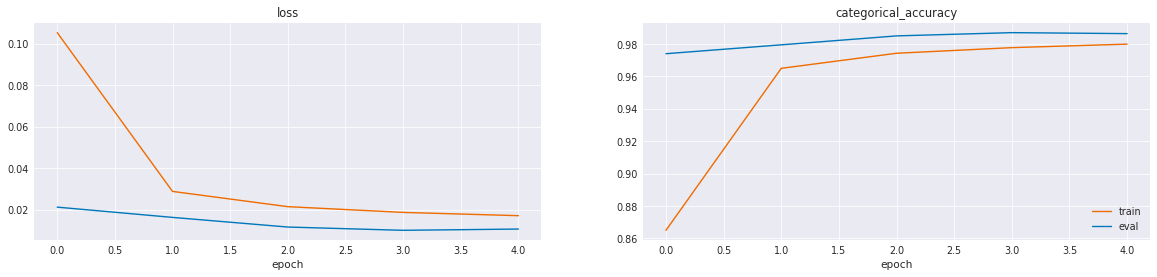

In [9]:
plotHistory(hist.history)